In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0627/weights_KD_segformer_0627_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0627(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0627(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.2
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 7s 539ms/step - loss: 0.1067
Average validation loss: 0.6570824980735779
4/4 [==============================] - 7s 553ms/step - loss: 0.1067 - val_loss: 0.6571
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 9s 537ms/step - loss: 0.0778 - val_loss: 0.6571
Average validation loss: 0.6466025114059448
4/4 [==============================] - 9s 549ms/step - loss: 0.0778 - val_loss: 0.6518
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 542ms/step - loss: 0.0589 - val_loss: 0.6518
Average validation loss: 0.59002685546875
4/4 [==============================] - 11s 555ms/step - loss: 0.0589 - val_loss: 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 5s 683ms/step - loss: 4.5977e-05
Average validation loss: 0.0
8/8 [==============================] - 6s 698ms/step - loss: 4.5977e-05 - val_loss: 0.0000e+00
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 659ms/step - loss: 4.9537e-05 - val_loss: 0.0000e+00
Average validation loss: 0.0
8/8 [==============================] - 11s 673ms/step - loss: 4.9537e-05 - val_loss: 0.0000e+00
Epoch 3/10
8/8 [==============================] - 17s 691ms/step - loss: 4.8414e-05 - val_loss: 0.0000e+00
Average validation loss: 0.0
8/8 [==============================] - 17s 700ms/step - loss: 4.8414e-05 - val_loss: 0.0000e+00
Epoch 4/10
8/8 [==============================] - 22s 686ms/step - loss: 4.7448e-05 - val_loss: 0.0000e+00
Average validation loss: 0.0
8/8 [=======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 691ms/step - loss: 1.2485e-04
Average validation loss: 0.12248098850250244
12/12 [==============================] - 8s 702ms/step - loss: 1.2485e-04 - val_loss: 0.1225
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 707ms/step - loss: 1.1678e-04 - val_loss: 0.1225
Average validation loss: 0.029389132318707805
12/12 [==============================] - 17s 718ms/step - loss: 1.1678e-04 - val_loss: 0.0759
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 712ms/step - loss: 1.0878e-04 - val_loss: 0.0759
Average validation loss: 0.07823433011717877
12/12 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 730ms/step - loss: 5.8182e-05
Average validation loss: 0.04559203569078818
16/16 [==============================] - 12s 741ms/step - loss: 5.8182e-05 - val_loss: 0.0456
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 737ms/step - loss: 5.4241e-05 - val_loss: 0.0456
Average validation loss: 0.04431558307260275
16/16 [==============================] - 24s 747ms/step - loss: 5.4241e-05 - val_loss: 0.0450
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 35s 713ms/step - loss: 5.3021e-05 - val_loss: 0.0450
Average validation loss: 0.014994173208833672
16/16 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 730ms/step - loss: 3.0409e-05
Average validation loss: 0.018746719416230916
20/20 [==============================] - 15s 740ms/step - loss: 3.0409e-05 - val_loss: 0.0187
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 732ms/step - loss: 2.8232e-05 - val_loss: 0.0187
Average validation loss: 0.02362860981374979
20/20 [==============================] - 30s 742ms/step - loss: 2.8232e-05 - val_loss: 0.0212
Epoch 3/10
20/20 [==============================] - 44s 713ms/step - loss: 2.7249e-05 - val_loss: 0.0212
Average validation loss: 0.04528900599107146
20/20 [==============================] - 44s 724ms/step - loss: 2.7249e-05 - val_loss: 0.0292
Epoch 4/10
20/20 [==============================] - 58s 712ms/step - loss: 2.5265e-05 - val_loss: 0.0292
Average validati

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 16s 677ms/step - loss: 6.0570e-05
Average validation loss: 0.026460311996440094
24/24 [==============================] - 16s 687ms/step - loss: 6.0570e-05 - val_loss: 0.0265
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 32s 660ms/step - loss: 4.8598e-05 - val_loss: 0.0265
Average validation loss: 0.017121656021724146
24/24 [==============================] - 33s 670ms/step - loss: 4.8598e-05 - val_loss: 0.0218
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 49s 659ms/step - loss: 3.9172e-05 - val_loss: 0.0218
Average validation loss: 0.03700148190061251
24/24 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 27s 686ms/step - loss: 9.0839e-05
Average validation loss: 0.08284396789968014
40/40 [==============================] - 28s 696ms/step - loss: 9.0839e-05 - val_loss: 0.0828
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 55s 681ms/step - loss: 8.0577e-05 - val_loss: 0.0828
Average validation loss: 0.036831650882959366
40/40 [==============================] - 55s 691ms/step - loss: 8.0577e-05 - val_loss: 0.0598
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 82s 671ms/step - loss: 7.4526e-05 - val_loss: 0.0598
Average validation loss: 0.05757267139852047
40/40 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 33s 690ms/step - loss: 4.9151e-05
Average validation loss: 0.01577479539749523
48/48 [==============================] - 34s 700ms/step - loss: 4.9151e-05 - val_loss: 0.0158
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 66s 680ms/step - loss: 3.4704e-05 - val_loss: 0.0158
Average validation loss: 0.019085682133057464
48/48 [==============================] - 67s 690ms/step - loss: 3.4704e-05 - val_loss: 0.0174
Epoch 3/10
48/48 [==============================] - 100s 687ms/step - loss: 2.7003e-05 - val_loss: 0.0174
Average validation loss: 0.018456691526807845
48/48 [==============================] - 100s 697ms/step - loss: 2.7003e-05 - val_loss: 0.0178
Epoch 4/10
48/48 [==============================] - 133s 684ms/step - loss: 2.2861e-05 - val_loss: 0.0178
Average vali

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 38s 686ms/step - loss: 7.7095e-05
Average validation loss: 0.0382590837024119
56/56 [==============================] - 39s 695ms/step - loss: 7.7095e-05 - val_loss: 0.0383
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 77s 681ms/step - loss: 5.0086e-05 - val_loss: 0.0383
Average validation loss: 0.020237461981845888
56/56 [==============================] - 78s 689ms/step - loss: 5.0086e-05 - val_loss: 0.0292
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 116s 684ms/step - loss: 3.7762e-05 - val_loss: 0.0292
Average validation loss: 0.014698949459541057
56/56 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 44s 681ms/step - loss: 4.5678e-05
Average validation loss: 0.08100238043311947
64/64 [==============================] - 44s 691ms/step - loss: 4.5678e-05 - val_loss: 0.0810
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 88s 680ms/step - loss: 3.0564e-05 - val_loss: 0.0810
Average validation loss: 0.0470510520881362
64/64 [==============================] - 88s 690ms/step - loss: 3.0564e-05 - val_loss: 0.0640
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 132s 681ms/step - loss: 2.4176e-05 - val_loss: 0.0640
Average validation loss: 0.014961557026254013
64/64 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 49s 682ms/step - loss: 3.2905e-05
Average validation loss: 0.07002827980452114
72/72 [==============================] - 50s 692ms/step - loss: 3.2905e-05 - val_loss: 0.0700
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 99s 683ms/step - loss: 2.4239e-05 - val_loss: 0.0700
Average validation loss: 0.012233051367931895
72/72 [==============================] - 100s 693ms/step - loss: 2.4239e-05 - val_loss: 0.0411
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 149s 680ms/step - loss: 1.8754e-05 - val_loss: 0.0411
Average validation loss: 0.011482159089710977
72/72 [=============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 55s 682ms/step - loss: 3.2963e-05
Average validation loss: 0.10382053889334202
80/80 [==============================] - 55s 692ms/step - loss: 3.2963e-05 - val_loss: 0.1038
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 110s 681ms/step - loss: 2.4191e-05 - val_loss: 0.1038
Average validation loss: 0.030292841140180826
80/80 [==============================] - 111s 692ms/step - loss: 2.4191e-05 - val_loss: 0.0671
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 165s 684ms/step - loss: 1.8428e-05 - val_loss: 0.0671
Average validation loss: 0.01063980597537011
80/80 [===========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 66s 684ms/step - loss: 6.7561e-05
Average validation loss: 0.028299273370066658
96/96 [==============================] - 67s 694ms/step - loss: 6.7561e-05 - val_loss: 0.0283
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 132s 679ms/step - loss: 4.8046e-05 - val_loss: 0.0283
Average validation loss: 0.019134907643698778
96/96 [==============================] - 133s 689ms/step - loss: 4.8046e-05 - val_loss: 0.0237
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 198s 680ms/step - loss: 3.6467e-05 - val_loss: 0.0237
Average validation loss: 0.019605209464013267
96/96 [=========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 82s 685ms/step - loss: 3.5260e-05
Average validation loss: 0.020479809617002805
120/120 [==============================] - 83s 695ms/step - loss: 3.5260e-05 - val_loss: 0.0205
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 164s 674ms/step - loss: 2.8115e-05 - val_loss: 0.0205
Average validation loss: 0.01516975403452913
120/120 [==============================] - 165s 684ms/step - loss: 2.8115e-05 - val_loss: 0.0178
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 246s 675ms/step - loss: 2.2501e-05 - val_loss: 0.0178
Average validation loss: 0.011481693123156826
120/120 [==============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 100s 694ms/step - loss: 2.9166e-05
Average validation loss: 0.014378835814164227
144/144 [==============================] - 101s 704ms/step - loss: 2.9166e-05 - val_loss: 0.0144
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 201s 693ms/step - loss: 2.0235e-05 - val_loss: 0.0144
Average validation loss: 0.011048199780311229
144/144 [==============================] - 203s 703ms/step - loss: 2.0235e-05 - val_loss: 0.0127
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 302s 692ms/step - loss: 1.5844e-05 - val_loss: 0.0127
Average validation loss: 0.011331611778587103
144/144 [===========

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 111s 695ms/step - loss: 1.4096e-05
Average validation loss: 0.04044011682271957
160/160 [==============================] - 113s 705ms/step - loss: 1.4096e-05 - val_loss: 0.0404
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 225s 702ms/step - loss: 1.1247e-05 - val_loss: 0.0404
Average validation loss: 0.007957693039497827
160/160 [==============================] - 227s 712ms/step - loss: 1.1247e-05 - val_loss: 0.0242
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 340s 705ms/step - loss: 8.7503e-06 - val_loss: 0.0242
Average validation loss: 0.007777558610541746
160/160 [============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 142s 709ms/step - loss: 5.1689e-05
Average validation loss: 0.025362141355872156
200/200 [==============================] - 144s 720ms/step - loss: 5.1689e-05 - val_loss: 0.0254
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 285s 705ms/step - loss: 3.5391e-05 - val_loss: 0.0254
Average validation loss: 0.0138910430110991
200/200 [==============================] - 287s 715ms/step - loss: 3.5391e-05 - val_loss: 0.0196
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 428s 706ms/step - loss: 2.8172e-05 - val_loss: 0.0196
Average validation loss: 0.010608461108058692
200/200 [=============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:15 - loss: 2.6990e-06

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 170s 710ms/step - loss: 2.8210e-05
Average validation loss: 0.02684414878798028
240/240 [==============================] - 173s 720ms/step - loss: 2.8210e-05 - val_loss: 0.0268
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 342s 703ms/step - loss: 1.8773e-05 - val_loss: 0.0268
Average validation loss: 0.012442612853677322
240/240 [==============================] - 344s 713ms/step - loss: 1.8773e-05 - val_loss: 0.0196
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0627/weights_KD_segformer_0627_20\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 513s 705ms/step - loss: 1.4287e-05 - val_loss: 0.0196
Average validation loss: 0.010516500522498973
240/240 [============

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.12790949563696927, 0.05889990824959681, 0.05149962443461311, 0.03814857575192036, 0.01783634013746632, 0.018217642983563563, 0.026747890315360564, 0.020527943883237944, 0.01852021253339834, 0.019480166337522177, 0.02085472922338557, 0.03546716267208685, 0.029799566243107405, 0.01682085631958398, 0.012721910414717666, 0.010771686135286848, 0.012930533783658755, 0.010864023610601636]
std_val_losses =  [0.18409890169069718, 0.05884993842048805, 0.04133356672072357, 0.042638419253308135, 0.015137719308573237, 0.01130216686153642, 0.01829727459865372, 0.012296678747594953, 0.013784081627720228, 0.03383625570996912, 0.031029006853124933, 0.062325908356037074, 0.07081700921913467, 0.0206737283373724, 0.012133329480605144, 0.007706564181641596, 0.008559437679689759, 0.006873193690342513]


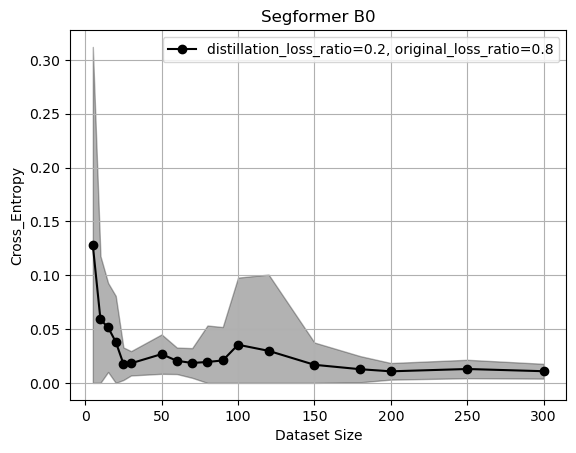

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0627')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0627_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0627_{int(teacher_ratio*100)}.png"))

plt.show()